# 最初のアシスタントを設定する

## アシスタントを作成する

### カーネルの選択を実施

<p>notebook で使うカーネルを選択します</p>

1. カーネルの選択を押下
   ![alt text](./docs/images/choice-kernel1.png)

1. virtualenv で作成した、`extension-lectures`配下の`extension-lectures\Scripts\python.exe`を選択する
   ![alt text](./docs/images/choice-kernel2.png)

1. カーネルの設定ができていることを確認する
   ![alt text](./docs/images/choice-kernel3.png)


### Azure OpenAI のクライアントを作成する


In [1]:
import os
import json
from openai import AzureOpenAI
from dotenv import load_dotenv

load_dotenv(verbose=True)


client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-05-01-preview",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
)

#### アシスタントの作成


In [2]:
assistant = client.beta.assistants.create(
    name="Data Visualization",
    instructions=f"You are a helpful AI assistant who makes interesting visualizations based on data."
    f"You have access to a sandboxed environment for writing and testing code."
    f"When you are asked to create a visualization you should follow these steps:"
    f"1. Write the code."
    f"2. Anytime you write new code display a preview of the code to show your work."
    f"3. Run the code to confirm that it runs."
    f"4. If the code is successful display the visualization."
    f"5. If the code is unsuccessful display the error message and try to revise the code and rerun going through the steps from above again.",
    tools=[{"type": "code_interpreter"}],
    model=f"{os.getenv("AZURE_OPENAI_MODEL_NAME")}",  # You must replace this value with the deployment name for your model.
)

#### アシスタントの内容の出力


In [3]:
print(assistant.model_dump_json(indent=2))

{
  "id": "asst_xm0EIOkfWMxOrP1BnZLcmdXZ",
  "created_at": 1726554542,
  "description": null,
  "instructions": "You are a helpful AI assistant who makes interesting visualizations based on data.You have access to a sandboxed environment for writing and testing code.When you are asked to create a visualization you should follow these steps:1. Write the code.2. Anytime you write new code display a preview of the code to show your work.3. Run the code to confirm that it runs.4. If the code is successful display the visualization.5. If the code is unsuccessful display the error message and try to revise the code and rerun going through the steps from above again.",
  "metadata": {},
  "model": "gpt-4o",
  "name": "Data Visualization",
  "object": "assistant",
  "tools": [
    {
      "type": "code_interpreter"
    }
  ],
  "response_format": "auto",
  "temperature": 1.0,
  "tool_resources": {
    "code_interpreter": {
      "file_ids": []
    },
    "file_search": null
  },
  "top_p": 1.0

#### スレッドを作成してみます


In [4]:
thread = client.beta.threads.create()
print(thread)

Thread(id='thread_lCSec4mGALFgXzyP80FXakXM', created_at=1726554559, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=None, file_search=None))


#### スレッドに追加する最初のユーザーの質問を作成


In [5]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id, role="user", content="Create a visualization of a sinewave"
)

#### スレッド メッセージを一覧表示する


In [6]:
thread_messages = client.beta.threads.messages.list(thread.id)
print(thread_messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_W7XmoTYjiN4rIEcpAyvClfyG",
      "assistant_id": null,
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Create a visualization of a sinewave"
          },
          "type": "text"
        }
      ],
      "created_at": 1726554564,
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "status": null,
      "thread_id": "thread_lCSec4mGALFgXzyP80FXakXM"
    }
  ],
  "object": "list",
  "first_id": "msg_W7XmoTYjiN4rIEcpAyvClfyG",
  "last_id": "msg_W7XmoTYjiN4rIEcpAyvClfyG",
  "has_more": false
}


#### スレッドを実行する


In [7]:
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    # instructions="New instructions" #You can optionally provide new instructions but these will override the default instructions
)

#### スレッド状態を取得する


In [8]:
# Retrieve the status of the run
run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)

status = run.status
print(status)

in_progress


#### 都度実行では大変なので、ループで状態監視をします


In [9]:
def check_status(thread, run):
    import time
    from IPython.display import clear_output

    start_time = time.time()

    status = run.status

    while status not in ["completed", "cancelled", "expired", "failed"]:
        time.sleep(5)
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        print(
            "Elapsed time: {} minutes {} seconds".format(
                int((time.time() - start_time) // 60),
                int((time.time() - start_time) % 60),
            )
        )
        status = run.status
        print(f"Status: {status}")
        clear_output(wait=True)

    messages = client.beta.threads.messages.list(thread_id=thread.id)

    print(f"Status: {status}")
    print(
        "Elapsed time: {} minutes {} seconds".format(
            int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)
        )
    )
    print(messages.model_dump_json(indent=2))

In [10]:
check_status(thread=thread, run=run)

Status: completed
Elapsed time: 0 minutes 6 seconds
{
  "data": [
    {
      "id": "msg_B2lgRgo83QPgR1KgCqImAo5o",
      "assistant_id": "asst_xm0EIOkfWMxOrP1BnZLcmdXZ",
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "image_file": {
            "file_id": "assistant-LqeqdbYWk9riJgmARBI1clUC",
            "detail": null
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Here's the visualization of a sine wave. The x-axis represents the values from 0 to \\(2\\pi\\), and the y-axis represents the sine of these values.\n\nIf you have any specific requests or further modifications in mind, please let me know!"
          },
          "type": "text"
        }
      ],
      "created_at": 1726554605,
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "object": "thread.message",
      "role": "assistant",
      "run_id": "ru

#### 実行後のスレッド メッセージを一覧表示する


In [11]:
messages = client.beta.threads.messages.list(thread_id=thread.id)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_B2lgRgo83QPgR1KgCqImAo5o",
      "assistant_id": "asst_xm0EIOkfWMxOrP1BnZLcmdXZ",
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "image_file": {
            "file_id": "assistant-LqeqdbYWk9riJgmARBI1clUC",
            "detail": null
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Here's the visualization of a sine wave. The x-axis represents the values from 0 to \\(2\\pi\\), and the y-axis represents the sine of these values.\n\nIf you have any specific requests or further modifications in mind, please let me know!"
          },
          "type": "text"
        }
      ],
      "created_at": 1726554605,
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "object": "thread.message",
      "role": "assistant",
      "run_id": "run_fcqgOJ9wSCcDzWuq3PEtmYVU",
      "status": null,
 

#### ファイル ID を取得する

モデルに正弦波の画像を生成させるように要求しました。 画像をダウンロードするには、まず画像ファイル ID を取得する必要があります。


In [12]:
data = json.loads(
    messages.model_dump_json(indent=2)
)  # Load JSON data into a Python object
image_file_id = data["data"][0]["content"][0]["image_file"]["file_id"]

print(image_file_id)  # Outputs: assistant-1YGVTvNzc2JXajI5JU9F0HMD

assistant-LqeqdbYWk9riJgmARBI1clUC


#### イメージをダウンロードする


In [13]:
content = client.files.content(image_file_id)

image = content.write_to_file("sinewave.png")

<p>ダウンロードしたら、画像をローカルで開きます。</p>


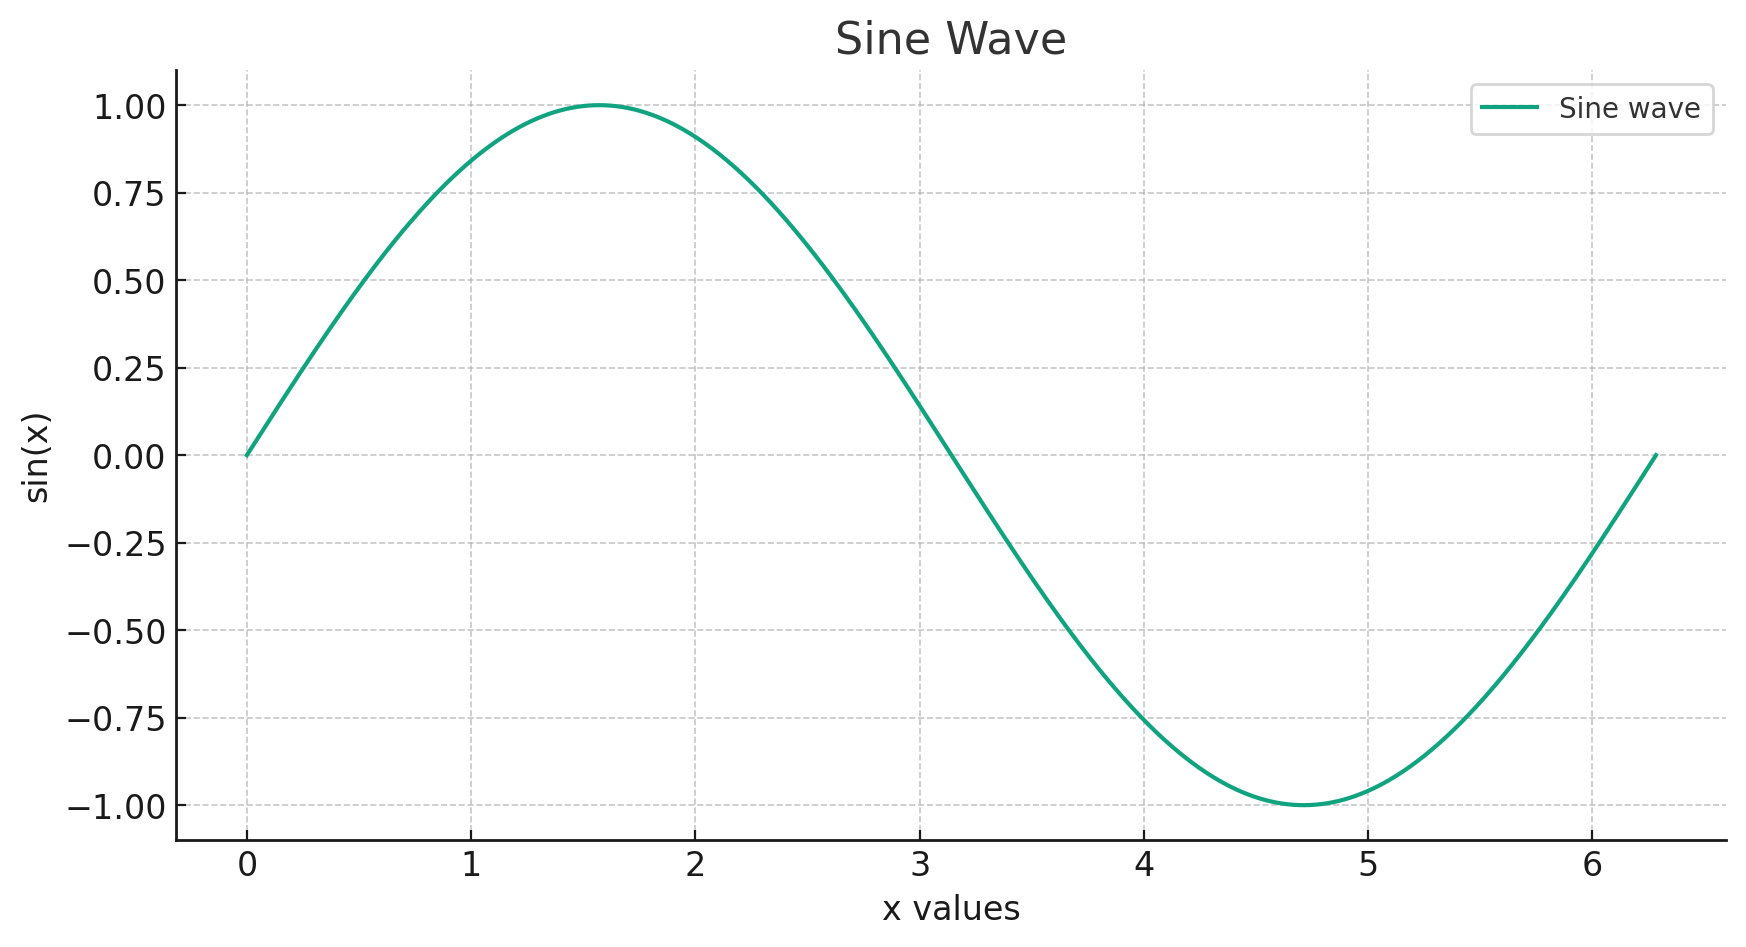

In [14]:
from PIL import Image
from IPython.display import display

# Display the image in the default image viewer
image = Image.open("sinewave.png")
# image.show()
display(image)

### スレッドでフォローアップの質問をする

アシスタントがこちらの指示に完全には従わず、応答のテキスト部分に実行されたコードが含まれていなかったため、明示的にその情報を要求してみます。


In [15]:
# Add a new user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Show me the code you used to generate the sinewave",
)

もう一度実行して、スレッドの状態を取得する必要があります。


In [16]:
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    # instructions="New instructions" #You can optionally provide new instructions  but these will override the default instructions
)

# Retrieve the status of the run
run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)

check_status(thread=thread, run=run)

Status: completed
Elapsed time: 0 minutes 16 seconds
{
  "data": [
    {
      "id": "msg_lFfhpRow61XCiBsqaAJUGZdn",
      "assistant_id": "asst_xm0EIOkfWMxOrP1BnZLcmdXZ",
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Of course! Here is the code that was used to generate the sinewave visualization:\n\n```python\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Generate x values\nx = np.linspace(0, 2 * np.pi, 1000)\n\n# Calculate sine of x\ny = np.sin(x)\n\n# Create a plot\nplt.figure(figsize=(10, 5))\nplt.plot(x, y, label='Sine wave')\nplt.title('Sine Wave')\nplt.xlabel('x values')\nplt.ylabel('sin(x)')\nplt.legend()\nplt.grid(True)\nplt.show()\n```\n\nThis code uses the `numpy` library to generate an array of x values ranging from 0 to \\(2\\pi\\). It then calculates the sine of these x values and uses the `matplotlib` library to plot the sinewave. The plot includes lab

実行状態が完了に達したら、スレッド内のメッセージを再度一覧表示します。これには、最新の質問への応答が含まれているはずです。


In [17]:
messages = client.beta.threads.messages.list(thread_id=thread.id)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_lFfhpRow61XCiBsqaAJUGZdn",
      "assistant_id": "asst_xm0EIOkfWMxOrP1BnZLcmdXZ",
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Of course! Here is the code that was used to generate the sinewave visualization:\n\n```python\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Generate x values\nx = np.linspace(0, 2 * np.pi, 1000)\n\n# Calculate sine of x\ny = np.sin(x)\n\n# Create a plot\nplt.figure(figsize=(10, 5))\nplt.plot(x, y, label='Sine wave')\nplt.title('Sine Wave')\nplt.xlabel('x values')\nplt.ylabel('sin(x)')\nplt.legend()\nplt.grid(True)\nplt.show()\n```\n\nThis code uses the `numpy` library to generate an array of x values ranging from 0 to \\(2\\pi\\). It then calculates the sine of these x values and uses the `matplotlib` library to plot the sinewave. The plot includes labels, a title, a legend, and a grid for better readabi

最新の質問に対する応答のみを抽出するには、以下を行います。


In [18]:
data = json.loads(messages.model_dump_json(indent=2))
code = data["data"][0]["content"][0]["text"]["value"]
print(code)

Of course! Here is the code that was used to generate the sinewave visualization:

```python
import matplotlib.pyplot as plt
import numpy as np

# Generate x values
x = np.linspace(0, 2 * np.pi, 1000)

# Calculate sine of x
y = np.sin(x)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Sine wave')
plt.title('Sine Wave')
plt.xlabel('x values')
plt.ylabel('sin(x)')
plt.legend()
plt.grid(True)
plt.show()
```

This code uses the `numpy` library to generate an array of x values ranging from 0 to \(2\pi\). It then calculates the sine of these x values and uses the `matplotlib` library to plot the sinewave. The plot includes labels, a title, a legend, and a grid for better readability.

If you have any other questions or requests, feel free to ask!


【演習】正弦波の視覚化を生成するために使ったコードを張り付けて実行してみましょう


Matplotlib is building the font cache; this may take a moment.


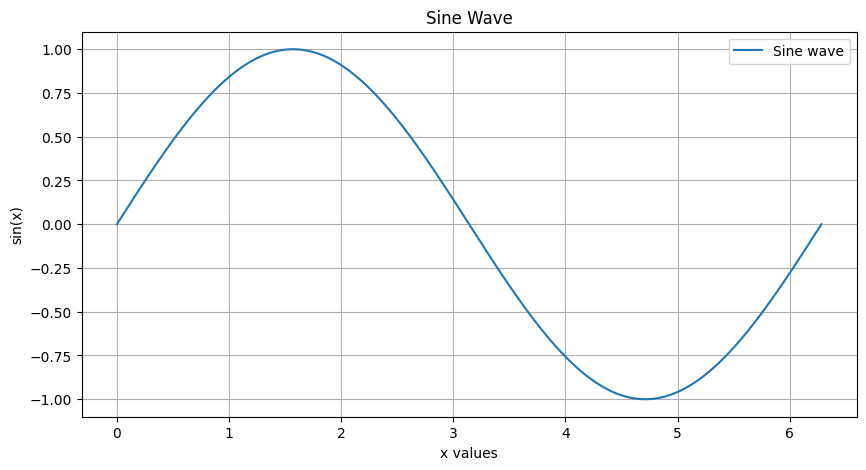

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values
x = np.linspace(0, 2 * np.pi, 1000)

# Calculate sine of x
y = np.sin(x)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Sine wave")
plt.title("Sine Wave")
plt.xlabel("x values")
plt.ylabel("sin(x)")
plt.legend()
plt.grid(True)
plt.show()

#### ダーク モード

最後の質問をスレッドに追加して、コード インタープリターがグラフをダーク モードに切り替えられるかどうかを確認してみましょう。


In [20]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="I prefer visualizations in darkmode can you change the colors to make a darkmode version of this visualization.",
)

# Run the thread
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
)

# Retrieve the status of the run
run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)

status = run.status
check_status(thread=thread, run=run)

Status: completed
Elapsed time: 0 minutes 11 seconds
{
  "data": [
    {
      "id": "msg_0Hz0BHagBk40z0IB9pddp4dc",
      "assistant_id": "asst_xm0EIOkfWMxOrP1BnZLcmdXZ",
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "image_file": {
            "file_id": "assistant-EwpOLiz4we8Lvni94cveuppR",
            "detail": null
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Here is the dark mode version of the sine wave visualization. The background color has been set to black, and the grid, labels, and sine wave color have been adjusted to make them more visible against the dark background. If you have any further customization requests or questions, feel free to let me know!"
          },
          "type": "text"
        }
      ],
      "created_at": 1726554863,
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "obj

In [21]:
messages = client.beta.threads.messages.list(thread_id=thread.id)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_0Hz0BHagBk40z0IB9pddp4dc",
      "assistant_id": "asst_xm0EIOkfWMxOrP1BnZLcmdXZ",
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "image_file": {
            "file_id": "assistant-EwpOLiz4we8Lvni94cveuppR",
            "detail": null
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Here is the dark mode version of the sine wave visualization. The background color has been set to black, and the grid, labels, and sine wave color have been adjusted to make them more visible against the dark background. If you have any further customization requests or questions, feel free to let me know!"
          },
          "type": "text"
        }
      ],
      "created_at": 1726554863,
      "incomplete_at": null,
      "incomplete_details": null,
      "metadata": {},
      "object": "thread.message",
      "role": "assistant",
  

新しい画像ファイル ID を抽出し、画像をダウンロードして表示します。


assistant-EwpOLiz4we8Lvni94cveuppR


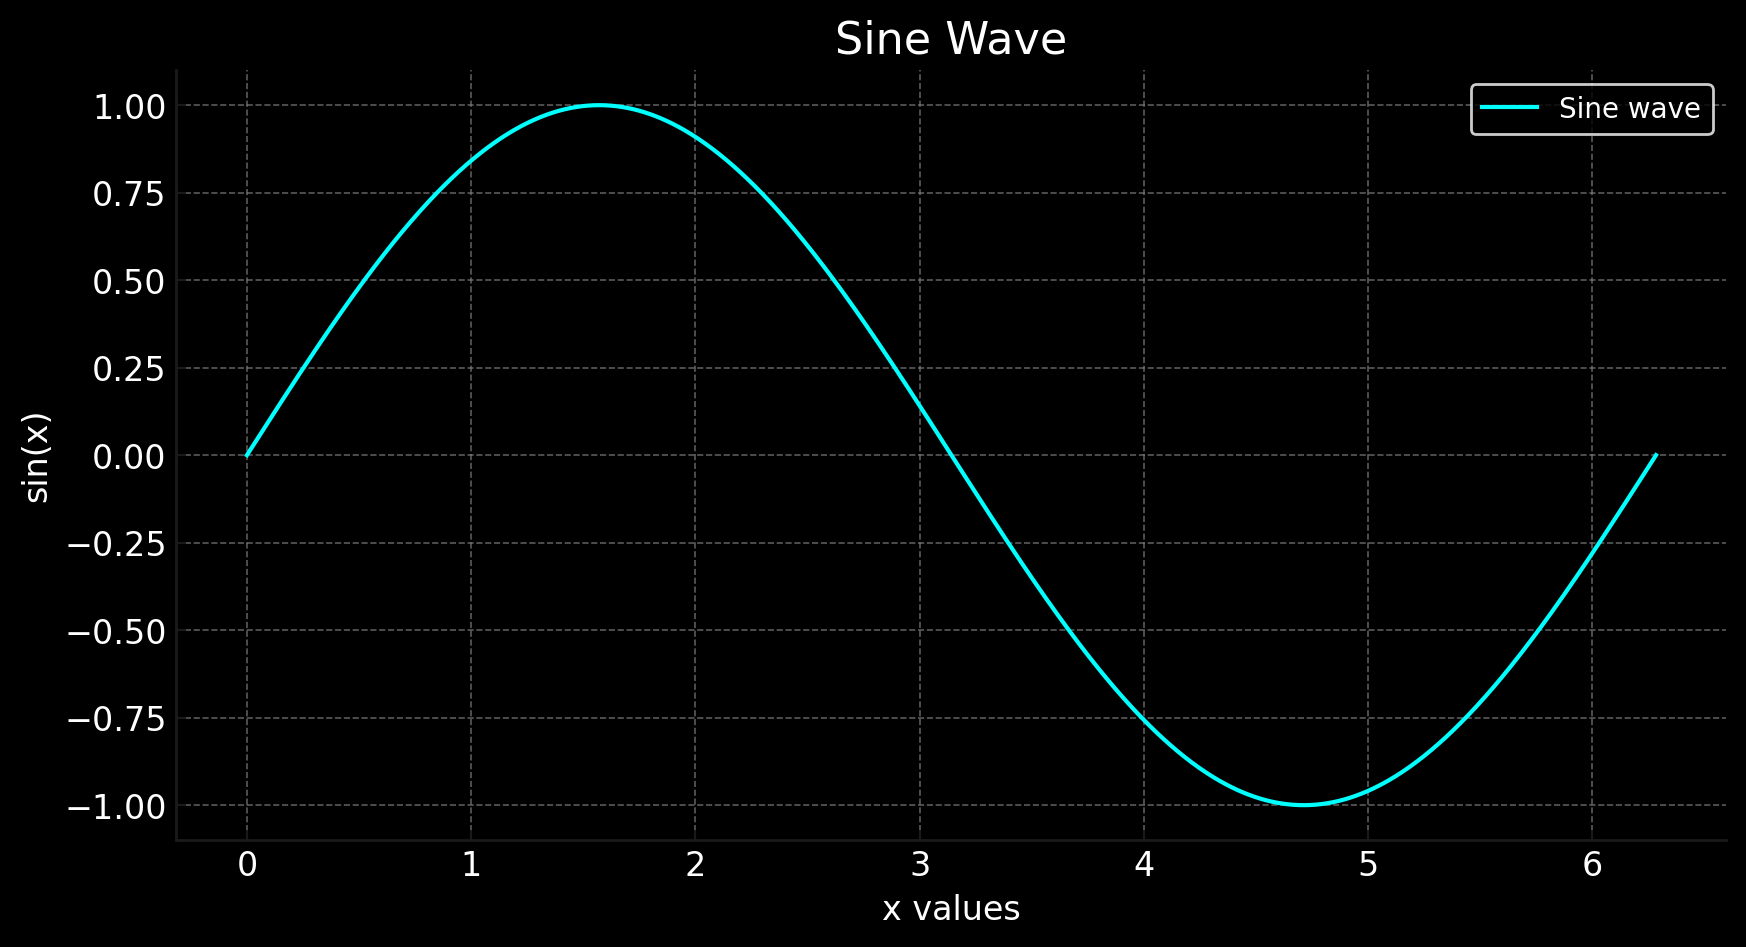

In [22]:
data = json.loads(
    messages.model_dump_json(indent=2)
)  # Load JSON data into a Python object
image_file_id = data[
    "data"
][
    0
][
    "content"
][
    0
][
    "image_file"
][
    "file_id"
]  # index numbers can vary if you have had a different conversation over the course of the thread.

print(image_file_id)

content = client.files.content(image_file_id)
image = content.write_to_file("dark_sine.png")

# Display the image in the default image viewer
image = Image.open("dark_sine.png")
# image.show()
display(image)

## 次の課題に移動へ

[Azure OpenAI + Logic Apps で天気を取得する(準備編)](./docs/logic-apps.markdown)

[README に戻る](./README.markdown)


In [23]:
# Add a new user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Show me the code you used to generate the sinewave",
)

もう一度実行して、スレッドの状態を取得する必要があります。


In [24]:
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    # instructions="New instructions" #You can optionally provide new instructions  but these will override the default instructions
)

# Retrieve the status of the run
run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)

check_status(thread=thread, run=run)

Status: completed
Elapsed time: 0 minutes 5 seconds
{
  "data": [
    {
      "id": "msg_D8raVbHZOSO1hpDFOypvTrcF",
      "assistant_id": "asst_xm0EIOkfWMxOrP1BnZLcmdXZ",
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Sure! Here is the code that was used to generate the dark mode version of the sinewave visualization:\n\n```python\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Generate x values\nx = np.linspace(0, 2 * np.pi, 1000)\n\n# Calculate sine of x\ny = np.sin(x)\n\n# Create a plot with dark mode settings\nplt.figure(figsize=(10, 5))\nplt.plot(x, y, label='Sine wave', color='cyan')\nplt.title('Sine Wave', color='white')\nplt.xlabel('x values', color='white')\nplt.ylabel('sin(x)', color='white')\nplt.legend(facecolor='black', edgecolor='white', labelcolor='white')\nplt.grid(True, color='gray')\n\n# Set the background color to black\nplt.gca().set_facecolor('black

実行状態が完了に達したら、スレッド内のメッセージを再度一覧表示します。これには、最新の質問への応答が含まれているはずです。


In [25]:
messages = client.beta.threads.messages.list(thread_id=thread.id)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_D8raVbHZOSO1hpDFOypvTrcF",
      "assistant_id": "asst_xm0EIOkfWMxOrP1BnZLcmdXZ",
      "attachments": [],
      "completed_at": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Sure! Here is the code that was used to generate the dark mode version of the sinewave visualization:\n\n```python\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Generate x values\nx = np.linspace(0, 2 * np.pi, 1000)\n\n# Calculate sine of x\ny = np.sin(x)\n\n# Create a plot with dark mode settings\nplt.figure(figsize=(10, 5))\nplt.plot(x, y, label='Sine wave', color='cyan')\nplt.title('Sine Wave', color='white')\nplt.xlabel('x values', color='white')\nplt.ylabel('sin(x)', color='white')\nplt.legend(facecolor='black', edgecolor='white', labelcolor='white')\nplt.grid(True, color='gray')\n\n# Set the background color to black\nplt.gca().set_facecolor('black')\nplt.gcf().set_facecolor('black')\n\n# Change the

最新の質問に対する応答のみを抽出するには、以下を行います。


In [26]:
data = json.loads(messages.model_dump_json(indent=2))
code = data["data"][0]["content"][0]["text"]["value"]
print(code)

Sure! Here is the code that was used to generate the dark mode version of the sinewave visualization:

```python
import matplotlib.pyplot as plt
import numpy as np

# Generate x values
x = np.linspace(0, 2 * np.pi, 1000)

# Calculate sine of x
y = np.sin(x)

# Create a plot with dark mode settings
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Sine wave', color='cyan')
plt.title('Sine Wave', color='white')
plt.xlabel('x values', color='white')
plt.ylabel('sin(x)', color='white')
plt.legend(facecolor='black', edgecolor='white', labelcolor='white')
plt.grid(True, color='gray')

# Set the background color to black
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')

# Change the color of the axis ticks
plt.xticks(color='white')
plt.yticks(color='white')

plt.show()
```

This code modifies the color settings to create a dark mode version of the plot. The background color is set to black, and various elements such as the sine wave, grid, labels, and axis ticks are given col

【演習】正弦波の視覚化を生成するために使ったコードを張り付けて実行してみましょう


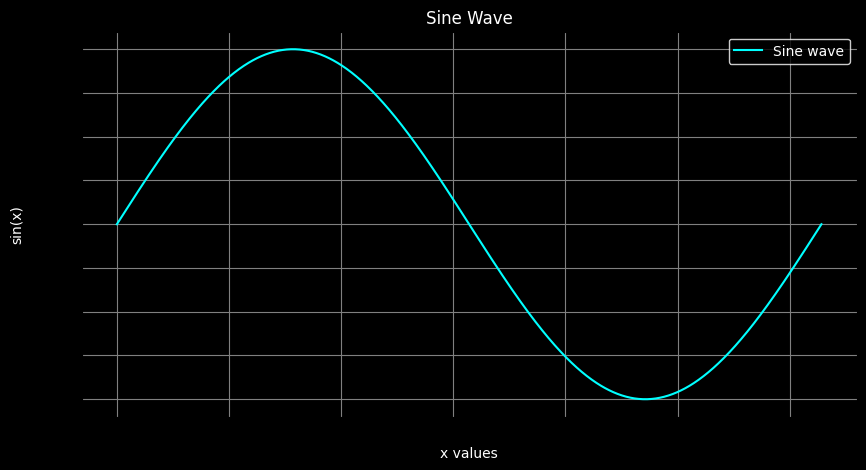

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values
x = np.linspace(0, 2 * np.pi, 1000)

# Calculate sine of x
y = np.sin(x)

# Create a plot with dark mode settings
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="Sine wave", color="cyan")
plt.title("Sine Wave", color="white")
plt.xlabel("x values", color="white")
plt.ylabel("sin(x)", color="white")
plt.legend(facecolor="black", edgecolor="white", labelcolor="white")
plt.grid(True, color="gray")

# Set the background color to black
plt.gca().set_facecolor("black")
plt.gcf().set_facecolor("black")